### Automated anomaly detection using PyOD and Auto-Sklearn
This notebook incorporates anomaly detection algorithms from PyOD into Auto-Sklearn. The following steps are followed:
- Auto-Sklearn is extended to incorporate PyOD algorithms
- Anomaly detection dataset(s) are imported and pre-processed
- Dataset is passed to Auto-Sklearn automl object for automated modeling and prediction
- Results and stats are obtained and analyzed

In [1]:
# Imports
import os, sys
import pandas as pd
from matplotlib import pyplot as plt
from datetime import timedelta as td
from sklearn.model_selection import train_test_split, PredefinedSplit, StratifiedShuffleSplit
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import roc_auc, average_precision
p = os.path.abspath('..')
sys.path.insert(1, p)
from utils import import_dataset, add_pyod_models_to_pipeline, balanced_split, get_metric_result
# Add models to Auto-Sklearn
add_pyod_models_to_pipeline()

In [2]:
import autosklearn.pipeline.components.data_preprocessing
from autosklearn.pipeline.components.base import AutoSklearnPreprocessingAlgorithm
from autosklearn.pipeline.constants import SPARSE, DENSE, UNSIGNED_DATA, INPUT
from ConfigSpace.configuration_space import ConfigurationSpace

class NoPreprocessing(AutoSklearnPreprocessingAlgorithm):

    def __init__(self, **kwargs):
        """ This preprocessors does not change the data """
        # Some internal checks makes sure parameters are set
        for key, val in kwargs.items():
            setattr(self, key, val)

    def fit(self, X, Y=None):
        return self

    def transform(self, X):
        return X

    @staticmethod
    def get_properties(dataset_properties=None):
        return {
            'shortname': 'NoPreprocessing',
            'name': 'NoPreprocessing',
            'handles_regression': True,
            'handles_classification': True,
            'handles_multiclass': True,
            'handles_multilabel': True,
            'handles_multioutput': True,
            'is_deterministic': True,
            'input': (SPARSE, DENSE, UNSIGNED_DATA),
            'output': (INPUT,)
        }

    @staticmethod
    def get_hyperparameter_search_space(dataset_properties=None):
        return ConfigurationSpace()  # Return an empty configuration as there is None

# Add NoPreprocessing component to auto-sklearn.
autosklearn.pipeline.components.data_preprocessing.add_preprocessor(NoPreprocessing)

In [3]:
# Classifiers to be included
classifiers = [
    'CBLOFClassifier',
    'COPODClassifier',
    'IForestClassifier',
    'KNNClassifier',
    'LOFClassifier',
]

In [5]:
# Datasets to be included
datasets = {
    #'cardio_02': '../../data/Cardiotocography_withoutdupl_norm_02_v10.arff',
    'cardio_05': '../../data/Cardiotocography_withoutdupl_norm_05_v10.arff',
    'cardio_10': '../../data/Cardiotocography_withoutdupl_norm_10_v10.arff',
    'cardio_20': '../../data/Cardiotocography_withoutdupl_norm_20_v10.arff',
    #'cardio_22': '../../data/Cardiotocography_withoutdupl_norm_22.arff'
}

In [6]:
# Sampling size
N = 5000
# Budget
total_budget = 300 # in seconds
per_run_budget = 30 # in seconds

# Performance dicts
valid_performance = {}
test_performance = {}

# Loop over datasets
for d_name, d_file in datasets.items():
    # Import DataFrame
    df = import_dataset(d_file)
    print('Dataset: {}, shape: {}'.format(d_name, df.shape))
    # Subsample
    if(len(df) > N):
        df = df.sample(n=N)
    # Extract X, y
    X  = df.iloc[:, :-1]
    y = df['outlier']
    # Split to train, test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

    # Choose validation set
    validation_type = 'stratified' # balanced vs stratified

    if validation_type == 'balanced':
        # Method 1 - Balanced split
        selected_indices = balanced_split(y_train)
        resampling_strategy = PredefinedSplit(test_fold=selected_indices)
    else:
        # Method 2 - Stratified Shuffle Split
        resampling_strategy = StratifiedShuffleSplit(n_splits=5, test_size=0.3)

    # Build autosklearn classifier
    automl = AutoSklearnClassifier(
        include = {
            'classifier': classifiers,
            'feature_preprocessor': ['no_preprocessing'],
            'data_preprocessor': ['NoPreprocessing']
        },
        exclude = None,
        metric = roc_auc,
        scoring_functions = [roc_auc, average_precision],
        time_left_for_this_task = total_budget,
        per_run_time_limit = per_run_budget,
        ensemble_size = 0,
        initial_configurations_via_metalearning = 0,
        resampling_strategy = resampling_strategy,
        get_smac_object_callback=None
    )
    # Fit
    print('Fitting..')
    automl.fit(X_train, y_train, X_test, y_test, dataset_name='Cardiotography')

    # Print stats
    print(automl.sprint_statistics())
    #print(get_metric_result(automl.cv_results_).to_string(index=False))
    #print('\n\n')
    # Store performance metrics
    valid_performance[d_name] = automl.performance_over_time_[['Timestamp', 'single_best_optimization_score']]
    test_performance[d_name] = automl.performance_over_time_[['Timestamp', 'single_best_test_score']]

Dataset: cardio_10, shape: (1831, 22)
Fitting..
[WARNING] [2022-03-17 16:39:24,869:Client-autosklearn.automl_common.common.utils.backend] Directory /tmp/auto-sklearn_tmp_5eaa576a-a5ff-11ec-8f5f-ab6c2fd0ae2a/.auto-sklearn/ensembles does not exist
auto-sklearn results:
  Dataset name: Cardiotography
  Metric: roc_auc
  Best validation score: 0.773108
  Number of target algorithm runs: 76
  Number of successful target algorithm runs: 74
  Number of crashed target algorithm runs: 2
  Number of target algorithms that exceeded the time limit: 0
  Number of target algorithms that exceeded the memory limit: 0



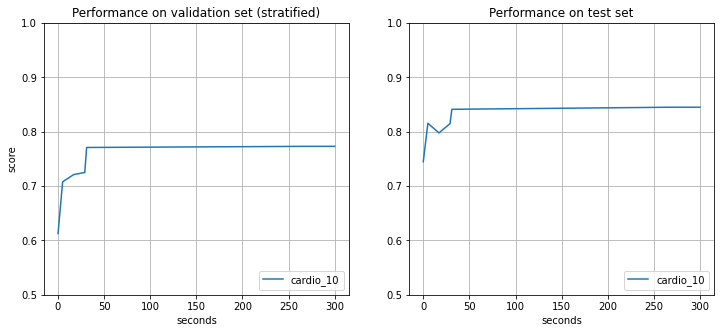

In [7]:
# Figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
#
# Plot validation performance
for d, results in valid_performance.items():
    # exctract series
    x1 = (results.Timestamp-results.Timestamp[0]).apply(td.total_seconds)
    y1 = results.single_best_optimization_score
    # modify for plotting
    x1.at[x1.shape[0]] = total_budget
    y1.at[y1.shape[0]] = y1.at[y1.shape[0]-1]
    ax1.plot(x1, y1)
ax1.legend(list(datasets.keys()), loc='lower right')
ax1.set_ylim([0.5, 1.])
ax1.set_xlabel('seconds')
ax1.set_ylabel('score')
ax1.set_title('Performance on validation set ({})'.format(validation_type))
ax1.grid()
#
# Plot test set performance
for d, results in test_performance.items():
    # exctract series
    x2 = (results.Timestamp-results.Timestamp[0]).apply(td.total_seconds)
    y2 = results.single_best_test_score
    # modify plotting
    x2.at[x2.shape[0]] = total_budget
    y2.at[y2.shape[0]] = y2.at[y2.shape[0]-1]
    ax2.plot(x2, y2)
ax2.legend(list(datasets.keys()), loc='lower right')
ax2.set_ylim([0.5, 1.])
ax2.set_xlabel('seconds')
#ax2.set_ylabel('score')
ax2.set_title('Performance on test set')
ax2.grid()